In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

# The Enerty-Water Nexus
__Data__
* Water use data 
* Energy use data from Local Law 84
* Building information from PLUTO

__Process__
* Merging water data + energy data (only focusing on residential buildings)
* Data cleaning
* Mergine water + energy data + PLUTO data
* Descriptive analysis of water + energy data
* Statistical learning to identify the relationship between building energy, water, and phsical characteristics or the building, focusing on building age and size

## 1. Merging water data + energy data
* only focusing on residential buildings
### 1) Water data

In [2]:
df_14 = pd.read_csv('../data/DSNYResidentialFinal_2014.csv', header = 1, dtype = {'BBL':str})
df_14.columns = ['BBL', '14Jan', '14Apr', '14Jul', '14Oct']
df_15 = pd.read_csv('../data/DSNYResidentialFinal_2015.csv', header = 1, dtype = {'BBL':str})
df_15.columns = ['BBL', '15Jan', '15Apr', '15Jul', '15Oct']
df_16 = pd.read_csv('../data/DSNYResidentialFinal_2016.csv', header = 1, dtype = {'BBL':str})
df_16.columns = ['BBL', '16Jan', '16Apr', '16Jul', '16Oct']
df_17 = pd.read_csv('../data/DSNYResidentialFinal_2017.csv', header = 1, dtype = {'BBL':str})
df_17 = df_17.drop('Unnamed: 3', axis=1)
df_17.columns = ['BBL', '17Jan', '17Apr']

# Merge data 2014 - 2017
dfs = [df_14, df_15, df_16, df_17]
df = reduce(lambda left,right: pd.merge(left,right,on='BBL', how = 'outer'), dfs)
print len(df)

# if you want to operate on multiple columns, put them in a list like so:
cols = df.columns.tolist()[1:]

# pass them to df.replace(), specifying each char and it's replacement:
df[cols] = df[cols].replace({',': ''}, regex=True)
df[cols] = df[cols].astype(float)

# Use only 2015 data to match with 2015 Local law 84 data
df = df[['BBL', '15Jan', '15Apr', '15Jul', '15Oct']]

df.head(2)

734879


,BBL,15Jan,15Apr,15Jul,15Oct
0,1000070038,3253.0,3002.0,4726.0,3758.0
1,1000087501,1700.0,850.0,8550.0,1550.0


### 2) Envergy use data from Local Law 84
* Selecting only residential buildings
* 'Primary Property Type - Self Selected' == 'Multifaily Housing'

In [3]:
# Load LL84 data 
ll84 = pd.read_csv('../data/LL84_2015_bbl_eui_flagged.csv', dtype={'new_bbl':str})
ll84 = ll84[ll84['Primary Property Type - Self Selected']=='Multifamily Housing']

In [4]:
#print ll84.columns.tolist()

In [5]:
ll84 = ll84[['new_bbl','Year Built', 'Number of Buildings', 'Occupancy',  
         'Site EUI (kBtu/ft_2)', 'Weather Normalized Site EUI (kBtu/ft_2)',
         'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)',    
         'Source EUI (kBtu/ft_2)', 'Weather Normalized Source EUI (kBtu/ft_2)',
         'Source Energy Use (kBtu)', 'Weather Normalized Source Energy Use (kBtu)',
         'Multifamily Housing - Gross Floor Area (ft_2)', 
         'Multifamily Housing - Government Subsidized Housing', 
         'Multifamily Housing - Number of Bedrooms', 
         'Multifamily Housing - Number of Laundry Hookups in All Units', 
         'Multifamily Housing - Number of Laundry Hookups in Common Area(s)', 
         'Multifamily Housing - Total Number of Residential Living Units', 
         'Multifamily Housing - Percent That Can Be Cooled', 
         'Multifamily Housing - Percent That Can Be Heated', 
         'Multifamily Housing - Number of Residential Living Units in a High-Rise Setting (10 or more Stories)', 
         'Multifamily Housing - Number of Residential Living Units in a Mid-Rise Setting (5-9 Stories)']]

ll84.columns = [['BBL', 'Year', 'NumBldg', 'Occ', 'Site EUI (kBtu/ft_2)', 'Weather Normalized Site EUI (kBtu/ft_2)',
         'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)', 'Source EUI (kBtu/ft_2)', 'Weather Normalized Source EUI (kBtu/ft_2)',
         'Source Energy Use (kBtu)', 'Weather Normalized Source Energy Use (kBtu)',
              'GFA', 'GovSub', 'NumBedrooms', 'NumLaundU', 'NumLaundC', 'NumResunits', 'Pcooled', 'Pheated',
              'NumResunitsHigh', 'NumResunitsMed']]

#ll84.head(2)

In [6]:
# Due to bugs, export the data and re-load the data
ll84.to_csv('../data/energy_res_ll84.csv', index=False)
df_energy = pd.read_csv('../data/energy_res_ll84.csv', dtype={'BBL':str})
#df_energy.head(2)

In [7]:
# Since there are multiple buildings with the same BBL ID, data should be integrated at BBL level
# .value_counts() print out the number of buildings associated with a unique BBL

df_energy_sum = df_energy.groupby('BBL', as_index=False)['Site EUI (kBtu/ft_2)', 'Weather Normalized Site EUI (kBtu/ft_2)',
         'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)', 'Source EUI (kBtu/ft_2)', 'Weather Normalized Source EUI (kBtu/ft_2)',
         'Source Energy Use (kBtu)', 'Weather Normalized Source Energy Use (kBtu)',
              'GFA', 'NumBedrooms', 'NumLaundU', 'NumLaundC', 'NumResunits', 
              'NumResunitsHigh', 'NumResunitsMed'].sum()
df_energy_mean = df_energy.groupby('BBL', as_index=False)['Year', 'Occ', 'Pcooled', 'Pheated'].mean()

In [8]:
df_energy_sum.head(2)

,BBL,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),GFA,NumBedrooms,NumLaundU,NumLaundC,NumResunits,NumResunitsHigh,NumResunitsMed
0,1000087501,137.2,139.2,23197779.8,23536662.5,234.2,233.8,39591528.2,39523035.8,132653.0,90.0,0.0,0.0,90.0,0.0,0.0
1,1000110014,76.3,76.0,4128290.0,4108320.1,117.5,116.3,6356169.6,6293464.0,52091.0,20.0,12.0,0.0,20.0,20.0,0.0


In [9]:
df_energy_mean.head(2)

,BBL,Year,Occ,Pcooled,Pheated
0,1000087501,1985.0,100.0,10.0,100.0
1,1000110014,1909.0,100.0,100.0,100.0


In [10]:
# Re-merge two dataset
print len(df_energy['BBL'].unique())
print len(df_energy_sum)
print len(df_energy_mean)
df_energy_final = pd.merge(df_energy_sum, df_energy_mean, how='left', on='BBL')
print len(df_energy_final)

# the final samples = 9,380 multifamily housings

9381
9380
9380
9380


In [11]:
df_energy_final.head(2)

,BBL,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),GFA,NumBedrooms,NumLaundU,NumLaundC,NumResunits,NumResunitsHigh,NumResunitsMed,Year,Occ,Pcooled,Pheated
0,1000087501,137.2,139.2,23197779.8,23536662.5,234.2,233.8,39591528.2,39523035.8,132653.0,90.0,0.0,0.0,90.0,0.0,0.0,1985.0,100.0,10.0,100.0
1,1000110014,76.3,76.0,4128290.0,4108320.1,117.5,116.3,6356169.6,6293464.0,52091.0,20.0,12.0,0.0,20.0,20.0,0.0,1909.0,100.0,100.0,100.0


In [12]:
# Checking NaN values
df_energy_final.isnull().sum()

BBL                                              0
Site EUI (kBtu/ft_2)                             0
Weather Normalized Site EUI (kBtu/ft_2)          0
Site Energy Use (kBtu)                           0
Weather Normalized Site Energy Use (kBtu)        0
Source EUI (kBtu/ft_2)                           0
Weather Normalized Source EUI (kBtu/ft_2)        0
Source Energy Use (kBtu)                         0
Weather Normalized Source Energy Use (kBtu)      0
GFA                                              0
NumBedrooms                                      0
NumLaundU                                        0
NumLaundC                                        0
NumResunits                                      0
NumResunitsHigh                                  0
NumResunitsMed                                   0
Year                                             0
Occ                                              0
Pcooled                                        739
Pheated                        

In [13]:
#print ll.columns.tolist()

### 3) Merging data water + energy

In [14]:
data = pd.merge(df_energy_final, df, how='inner', on='BBL')
print len(data)

8173


In [15]:
data.head(2)

,BBL,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),GFA,...,NumResunitsHigh,NumResunitsMed,Year,Occ,Pcooled,Pheated,15Jan,15Apr,15Jul,15Oct
0,1000087501,137.2,139.2,23197779.8,23536662.5,234.2,233.8,39591528.2,39523035.8,132653.0,...,0.0,0.0,1985.0,100.0,10.0,100.0,1700.0,850.0,8550.0,1550.0
1,1000150022,84.1,83.3,28157234.5,27880138.8,163.7,160.0,54811785.9,53577797.5,333921.0,...,291.0,0.0,1931.0,100.0,100.0,100.0,30500.0,24500.0,32300.0,27200.0


## 2. Data cleaning

In [16]:
data.isnull().sum()

BBL                                              0
Site EUI (kBtu/ft_2)                             0
Weather Normalized Site EUI (kBtu/ft_2)          0
Site Energy Use (kBtu)                           0
Weather Normalized Site Energy Use (kBtu)        0
Source EUI (kBtu/ft_2)                           0
Weather Normalized Source EUI (kBtu/ft_2)        0
Source Energy Use (kBtu)                         0
Weather Normalized Source Energy Use (kBtu)      0
GFA                                              0
NumBedrooms                                      0
NumLaundU                                        0
NumLaundC                                        0
NumResunits                                      0
NumResunitsHigh                                  0
NumResunitsMed                                   0
Year                                             0
Occ                                              0
Pcooled                                        563
Pheated                        

In [17]:
# Drop rows with NaN water data
data = data[data['15Jan'].notnull()]
data.isnull().sum()

BBL                                              0
Site EUI (kBtu/ft_2)                             0
Weather Normalized Site EUI (kBtu/ft_2)          0
Site Energy Use (kBtu)                           0
Weather Normalized Site Energy Use (kBtu)        0
Source EUI (kBtu/ft_2)                           0
Weather Normalized Source EUI (kBtu/ft_2)        0
Source Energy Use (kBtu)                         0
Weather Normalized Source Energy Use (kBtu)      0
GFA                                              0
NumBedrooms                                      0
NumLaundU                                        0
NumLaundC                                        0
NumResunits                                      0
NumResunitsHigh                                  0
NumResunitsMed                                   0
Year                                             0
Occ                                              0
Pcooled                                        529
Pheated                        

In [18]:
print len(data)

7609


### The number of multi-unit residential buildings (BBLs) with both energy use data and water use data is 7,609

In [19]:
# Create a new column of average weekly water use ignoring seasonal change
data['avgW'] = data[['15Jan', '15Apr', '15Jul', '15Oct']].mean(axis=1)
data.head(2)

,BBL,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),GFA,...,NumResunitsMed,Year,Occ,Pcooled,Pheated,15Jan,15Apr,15Jul,15Oct,avgW
0,1000087501,137.2,139.2,23197779.8,23536662.5,234.2,233.8,39591528.2,39523035.8,132653.0,...,0.0,1985.0,100.0,10.0,100.0,1700.0,850.0,8550.0,1550.0,3162.5
1,1000150022,84.1,83.3,28157234.5,27880138.8,163.7,160.0,54811785.9,53577797.5,333921.0,...,0.0,1931.0,100.0,100.0,100.0,30500.0,24500.0,32300.0,27200.0,28625.0


## 3. Mergine water + energy data + PLUTO data

In [20]:
# Load 2015 pluto
mn = pd.read_csv('../data/pluto15/MN.csv', dtype={'BBL':str})
bx = pd.read_csv('../data/pluto15/BX.csv', dtype={'BBL':str})
bk = pd.read_csv('../data/pluto15/BK.csv', dtype={'BBL':str})
qn = pd.read_csv('../data/pluto15/QN.csv', dtype={'BBL':str})
si = pd.read_csv('../data/pluto15/SI.csv', dtype={'BBL':str})
boros = [mn, bx, bk, qn, si]

nyc = pd.concat(boros)

#### Categorize residential building type 
Residential building (One family, Two family, Walkup, Elevator apartment, Condominium (Residential area dominated), Multiple use residence, NYCHA)
* One family dwellings: ['BldgClass'].str[0]=='A'
* Two family dwellings: ['BldgClass'].str[0]=='B'
* Walkup apartment: ['BldgClass'].str[0]=='C'
* Elevator apartment: ['BldgClass'].str[0]=='D' excluding ['OwnerName']=='NYC HOUSING AUTHORITY'
* Condominium: ['BldgClass'].str[0]=='R' & ['ResArea']>0
* Multiple use residence: ['BldgClass'].str[0]=='S'
* NYCHA Housing: ['OwnerName']=='NYC HOUSING AUTHORITY'

Office building
* ['BldgClss'].str(0) == 'O'

In [21]:
# Add columns to mark building type
nyc['BldgType'] = 'Others'
nyc['BldgType'][nyc['BldgClass'].str[0]=='A'] = 'A'
nyc['BldgType'][nyc['BldgClass'].str[0]=='B'] = 'B'
nyc['BldgType'][nyc['BldgClass'].str[0]=='C']= 'C'
nyc['BldgType'][(nyc['BldgClass'].str[0]=='D') & (nyc['OwnerName']!='NYC HOUSING AUTHORITY')] = 'D'
nyc['BldgType'][(nyc['BldgClass'].str[0]=='R') & (nyc['ResArea']>0)] = 'R'
nyc['BldgType'][nyc['BldgClass'].str[0]=='S'] = 'S'
nyc['BldgType'][nyc['OwnerName']=='NYC HOUSING AUTHORITY'] = 'P'
nyc['BldgType'][nyc['BldgClass'].str[0] == 'O'] = 'O'

nyc = nyc[['BBL', 'BldgType', 'BldgClass', 'LandUse', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea', 
               'RetailArea', 'NumFloors', 'UnitsTotal', 'AssessTot', 'YearBuilt', 'UnitsRes', 'BuiltFAR']] 


In [22]:
# Merge with energy+water data (7,609 buildings)
data = pd.merge(data, nyc, how='left', on='BBL')
print len(data)

7609


In [23]:
#print data.columns.tolist()

In [24]:
data['Year_cleaned'] = data[["Year", "YearBuilt"]].max(axis=1)
data['NumResU_cleaned'] = data[['NumResunits', 'UnitsRes']].max(axis=1)
data['GFA_cleaned'] = data[['BldgArea', 'GFA']].max(axis=1)
data = data[['BBL', 'Site EUI (kBtu/ft_2)', 'Weather Normalized Site EUI (kBtu/ft_2)',
         'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)', 'Source EUI (kBtu/ft_2)', 
             'Weather Normalized Source EUI (kBtu/ft_2)', 'Source Energy Use (kBtu)',
             'Weather Normalized Source Energy Use (kBtu)', 'GFA_cleaned', 'NumBedrooms', 'NumLaundU', 'NumLaundC', 
             'NumResU_cleaned', 'NumResunitsHigh', 'NumResunitsMed', 'Year_cleaned', 'Occ', 'Pcooled', 'Pheated', 
             '15Jan', '15Apr', '15Jul', '15Oct', 'avgW', 'BldgType', 'BldgClass', 
             'LandUse', 'LotArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'NumFloors', 
             'UnitsTotal', 'AssessTot', 'BuiltFAR']]

In [25]:
data = data[data['ResArea']!=0] # PLUTO data provides some missing values --> drop
data.head()

,BBL,Site EUI (kBtu/ft_2),Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),Weather Normalized Site Energy Use (kBtu),Source EUI (kBtu/ft_2),Weather Normalized Source EUI (kBtu/ft_2),Source Energy Use (kBtu),Weather Normalized Source Energy Use (kBtu),GFA_cleaned,...,LandUse,LotArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsTotal,AssessTot,BuiltFAR
0,1000087501,137.2,139.2,23197779.8,23536662.5,234.2,233.8,39591528.2,39523035.8,169061.0,...,4,9053.0,42641.0,126420.0,0.0,42641.0,19.0,98.0,16133400.0,18.67
1,1000150022,84.1,83.3,28157234.5,27880138.8,163.7,160.0,54811785.9,53577797.5,335746.0,...,3,13465.0,4000.0,331746.0,0.0,4000.0,31.0,295.0,26322300.0,24.93
2,1000157502,42.7,41.3,9707762.8,9388616.4,128.0,123.6,29111469.8,28109350.2,207463.0,...,4,13928.0,10000.0,168748.0,0.0,10000.0,45.0,284.0,27791116.0,12.83
3,1000160015,42.3,41.6,9414329.4,9254204.2,92.4,89.4,20536672.1,19873788.6,239165.0,...,3,31141.0,8400.0,230765.0,0.0,0.0,9.0,209.0,19073250.0,7.68
4,1000160020,50.5,51.2,11645952.6,11806026.4,99.8,99.8,23022514.5,23029747.7,230765.0,...,3,29700.0,0.0,230765.0,0.0,0.0,9.0,210.0,17267850.0,7.77


In [26]:
print len(data)

7578


In [27]:
data.to_csv('../data/energy_water_pluto.csv', index=False)

# Final samples = 7,578

## 4. Descriptive analysis of water + energy data
* Bldg class count
* Bldg characteristics description (area, units, resunits, bedrooms, %of residential area)
* Energy use and water use descriptive statistics


In [28]:
data = pd.read_csv('../data/energy_water_pluto.csv', dtype={'BBL':str})
# Create normalized water use columns
data['avgW_pu'] = data['avgW'] / data['UnitsTotal']
data['avgW_sqft'] = data['avgW'] / data['GFA_cleaned']

# Create the percentage of residential area column
data['percent_res'] = data['ResArea']/data['GFA_cleaned']

In [29]:
data['BldgType'].value_counts()

D    6094
R     837
C     638
P       5
Name: BldgType, dtype: int64

In [30]:
data['bldgsize'] = 'high'
data['bldgsize'][data['NumFloors']<=7] = 'low'
data['bldgsize'].value_counts()

low     4705
high    2873
Name: bldgsize, dtype: int64

In [31]:
data['bldgsize'].value_counts(normalize=True)

low     0.620876
high    0.379124
Name: bldgsize, dtype: float64

In [32]:
data['bldgage'] = 'post-war'
data['bldgage'][data['Year_cleaned']<1940] = 'pre-war'
data['bldgage'][data['Year_cleaned']>=1980] = 'modern'
data['bldgage'].value_counts()

pre-war     3504
post-war    2884
modern      1190
Name: bldgage, dtype: int64

In [33]:
data['bldgage'].value_counts(normalize=True)

pre-war     0.462391
post-war    0.380575
modern      0.157034
Name: bldgage, dtype: float64

In [34]:
print data.columns.tolist()

['BBL', 'Site EUI (kBtu/ft_2)', 'Weather Normalized Site EUI (kBtu/ft_2)', 'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)', 'Source EUI (kBtu/ft_2)', 'Weather Normalized Source EUI (kBtu/ft_2)', 'Source Energy Use (kBtu)', 'Weather Normalized Source Energy Use (kBtu)', 'GFA_cleaned', 'NumBedrooms', 'NumLaundU', 'NumLaundC', 'NumResU_cleaned', 'NumResunitsHigh', 'NumResunitsMed', 'Year_cleaned', 'Occ', 'Pcooled', 'Pheated', '15Jan', '15Apr', '15Jul', '15Oct', 'avgW', 'BldgType', 'BldgClass', 'LandUse', 'LotArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'NumFloors', 'UnitsTotal', 'AssessTot', 'BuiltFAR', 'avgW_pu', 'avgW_sqft', 'percent_res', 'bldgsize', 'bldgage']


In [35]:
pd.set_option('float_format', '{:.2f}'.format)
data[['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,7578.00,7578.00,7578.00,7578.00,7574.00
mean,150794.68,203.92,139.38,1949.43,9.88
std,291446.32,432.69,288.17,27.43,7.45
min,4200.00,0.00,4.00,1836.00,0.00
50%,91993.50,121.12,84.00,1941.00,6.00
max,14217119.00,21828.00,10914.00,2019.00,76.00


In [36]:
data[data['BldgType']== 'C'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,638.00,638.00,638.00,638.00,638.00
mean,101952.37,175.04,113.04,1935.00,4.31
std,84788.40,170.35,100.35,17.15,1.43
min,4200.00,0.00,4.00,1898.00,2.00
50%,71461.50,113.52,73.00,1928.00,5.00
max,776424.00,1560.00,864.00,2012.00,13.00


In [37]:
data[data['BldgType']== 'D'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,6094.00,6094.00,6094.00,6094.00,6094.00
mean,150963.62,203.77,140.47,1947.45,9.79
std,307741.70,457.23,304.37,24.88,6.56
min,29000.00,0.00,7.00,1850.00,0.00
50%,91599.50,121.00,84.00,1941.00,6.00
max,14217119.00,21828.00,10914.00,2015.00,59.00


In [38]:
data[data['BldgType']== 'R'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,837.00,837.00,837.00,837.00,837.00
mean,185997.38,225.44,149.56,1974.49,14.79
std,266034.56,386.05,259.95,35.37,11.83
min,16599.00,5.00,5.00,1836.00,1.00
50%,110958.00,134.00,88.00,1987.00,12.00
max,3765613.00,6003.00,4064.00,2019.00,76.00


In [39]:
data[data['BldgType']== 'P'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,5.00,5.00,5.00,5.00,5.00
mean,256750.60,436.80,422.80,1973.80,12.40
std,152659.96,297.13,451.35,12.15,8.14
min,127942.00,150.00,114.00,1963.00,3.00
50%,179600.00,312.00,210.00,1967.00,12.00
max,449700.00,763.00,1197.00,1988.00,22.00


In [40]:
data[data['bldgsize']== 'low'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,4705.00,4705.00,4705.00,4705.00,4705.00
mean,101838.64,147.30,100.13,1944.31,5.75
std,94800.03,169.47,99.86,22.77,0.96
min,4200.00,0.00,4.00,1875.00,0.00
50%,77000.00,108.00,75.34,1939.00,6.00
max,2075590.00,3772.00,1896.00,2019.00,7.00


In [41]:
data[data['bldgsize']== 'high'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,2873.00,2873.00,2873.00,2873.00,2869.00
mean,230968.06,296.65,203.66,1957.81,16.65
std,446114.12,658.06,442.83,31.97,8.45
min,27196.00,0.00,5.00,1836.00,8.00
50%,137909.00,166.00,117.00,1961.00,14.00
max,14217119.00,21828.00,10914.00,2015.00,76.00


In [42]:
data[data['bldgage']== 'pre-war'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,3504.00,3504.00,3504.00,3504.00,3504.00
mean,97583.37,126.58,84.59,1925.96,8.20
std,75303.39,104.95,73.15,8.86,4.27
min,21888.00,0.00,6.00,1836.00,0.00
50%,75313.00,100.97,67.00,1927.00,6.00
max,1396625.00,2364.08,1590.00,1939.50,45.00


In [43]:
data[data['bldgage']== 'post-war'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,2884.00,2884.00,2884.00,2884.00,2883.00
mean,204863.80,293.73,198.53,1957.51,9.96
std,436881.22,665.53,416.81,9.65,7.19
min,4200.00,0.00,4.00,1940.00,2.00
50%,117589.00,160.00,114.00,1959.00,6.00
max,14217119.00,21828.00,10914.00,1979.00,57.00


In [44]:
data[data['bldgage']== 'modern'][['GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'Year_cleaned', 'NumFloors']].describe(percentiles=[.5])

,GFA_cleaned,NumBedrooms,NumResU_cleaned,Year_cleaned,NumFloors
count,1190.00,1190.00,1190.00,1190.00,1187.00
mean,176439.30,214.03,157.38,1998.95,14.67
std,213768.89,222.20,273.02,10.01,12.00
min,16599.00,0.00,5.00,1980.00,0.00
50%,112301.50,146.78,101.00,2003.00,10.00
max,4786701.00,2742.00,8018.00,2019.00,76.00


In [45]:
data[['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,7578.00,7578.00,7578.00,7578.00,7578.00,7574.00,7578.00
mean,420.06,59749092.03,550.41,73876306.84,23778.59,210.25,0.18
std,10121.96,1520266138.06,11121.96,1645006534.24,75727.52,530.61,0.29
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,79.40,6808312.30,117.85,9894506.25,13402.50,142.33,0.12
max,798135.70,110259162590.00,838112.30,115942021091.00,3748335.50,36325.00,10.25


In [46]:
data[data['BldgType']== 'C'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,638.00,638.00,638.00,638.00,638.00,638.00,638.00
mean,201.00,14614583.17,393.28,30477118.47,20970.76,245.12,0.24
std,990.71,88601239.96,3022.46,276554202.70,17582.41,199.92,0.20
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,96.60,6489070.25,133.75,9114067.40,17008.38,186.62,0.19
max,15663.60,1612728682.50,49025.30,5047645346.40,170392.50,1402.56,1.76


In [47]:
data[data['BldgType']== 'D'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,6094.00,6094.00,6094.00,6094.00,6094.00,6094.00,6094.00
mean,295.52,48377126.60,398.16,58544376.59,24666.44,205.73,0.18
std,4266.58,1495481090.23,5502.96,1596039018.79,83239.00,342.84,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,78.50,6731524.35,115.50,9655862.10,13354.00,142.26,0.12
max,157874.70,110259162590.00,192770.30,115942021091.00,3748335.50,11991.21,10.25


In [48]:
data[data['BldgType']== 'R'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,837.00,837.00,837.00,837.00,837.00,837.00,837.00
mean,1497.60,177410156.76,1783.47,219103491.72,19199.70,216.23,0.11
std,28175.28,2150598735.16,29862.07,2424390868.74,34325.40,1289.22,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,77.10,7869224.40,136.70,14061806.40,10887.50,125.44,0.09
max,798135.70,45413922873.30,838112.30,47688587624.50,516373.50,36325.00,3.44


In [49]:
data[data['BldgType']== 'P'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,78.74,24235381.34,116.88,37069980.84,78435.30,264.93,0.30
std,73.25,23660426.00,107.62,37613865.27,48378.50,142.97,0.08
min,0.00,0.00,0.00,0.00,25725.00,72.90,0.19
50%,111.90,27256696.50,174.20,35239992.70,74185.00,310.38,0.30
max,151.80,50321736.50,214.00,78354879.20,136876.50,436.38,0.41


In [50]:
data[data['bldgsize']== 'low'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,4705.00,4705.00,4705.00,4705.00,4705.00,4705.00,4705.00
mean,341.21,18076718.51,443.54,24254291.52,19762.66,224.94,0.21
std,12001.67,663176975.85,12867.93,706001380.31,52031.81,336.91,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,80.90,6085326.30,114.90,8599620.00,13150.00,155.09,0.15
max,798135.70,45413922873.30,838112.30,47688587624.50,2786667.50,6962.64,8.11


In [51]:
data[data['bldgsize']== 'high'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,2873.00,2873.00,2873.00,2873.00,2873.00,2869.00,2873.00
mean,549.19,127994312.16,725.43,155140345.16,30355.32,186.16,0.13
std,5860.87,2317251186.45,7422.13,2512399891.08,103079.60,745.87,0.24
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,76.90,9383500.30,123.20,15281406.50,14276.75,124.32,0.09
max,131121.40,110259162590.00,158829.00,115942021091.00,3748335.50,36325.00,10.25


In [52]:
data[data['bldgage']== 'pre-war'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,3504.00,3504.00,3504.00,3504.00,3504.00,3504.00,3504.00
mean,186.25,14616181.63,259.19,19831166.97,17218.29,237.17,0.20
std,3228.60,266807953.59,4103.97,323352436.58,25160.23,330.63,0.28
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,77.65,5959731.05,112.40,8423560.35,11748.75,164.60,0.14
max,157874.70,13231291569.90,192770.30,15958940244.90,563973.75,6962.64,6.34


In [53]:
data[data['bldgage']== 'post-war'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,2884.00,2884.00,2884.00,2884.00,2884.00,2883.00,2884.00
mean,497.69,99435365.85,686.58,119802988.89,33013.41,180.31,0.17
std,5358.81,2183504538.33,7101.17,2335855439.27,117480.48,354.38,0.33
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,81.75,8435141.10,119.30,12159125.85,15518.12,129.81,0.12
max,115367.90,110259162590.00,158829.00,115942021091.00,3748335.50,11991.21,10.25


In [54]:
data[data['bldgage']== 'modern'][['Weather Normalized Site EUI (kBtu/ft_2)','Weather Normalized Site Energy Use (kBtu)',
      'Weather Normalized Source EUI (kBtu/ft_2)', 'Weather Normalized Source Energy Use (kBtu)',
    'avgW', 'avgW_pu', 'avgW_sqft']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),Weather Normalized Source EUI (kBtu/ft_2),Weather Normalized Source Energy Use (kBtu),avgW,avgW_pu,avgW_sqft
count,1190.00,1190.00,1190.00,1190.00,1190.00,1187.00,1190.00
mean,920.42,96463801.54,1077.91,121709600.21,20714.80,203.48,0.13
std,23497.44,1716717664.31,24815.53,1921094260.63,29515.94,1079.52,0.15
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,78.25,7853293.55,134.10,13388919.95,13354.00,127.60,0.11
max,798135.70,45413922873.30,838112.30,47688587624.50,669064.75,36325.00,3.84


In [55]:
# data.boxplot(column='Site EUI (kBtu/ft_2)', by='BldgType', figsize=(16,8),  sym='',showmeans=True)
# data.boxplot(column='Source EUI (kBtu/ft_2)', by='BldgType', figsize=(16,8),  sym='',showmeans=True)

## 5. Statistical learning to identify the relationship between building energy, water, and phsical characteristics or the building, focusing on building age and size

* Remove outliers
* Correlation test - pearson and spearman
* energy vs. water (scatter) 
* Clustering
* Correlation test of supgroup

### (1) Remove outlier


In [56]:
# Remove outliers above +2std or below -2std

data = data[(data['Weather Normalized Site EUI (kBtu/ft_2)'] > data['Weather Normalized Site EUI (kBtu/ft_2)'].mean() 
             - 2*data['Weather Normalized Site EUI (kBtu/ft_2)'].std()) & 
           (data['Weather Normalized Site EUI (kBtu/ft_2)'] < data['Weather Normalized Site EUI (kBtu/ft_2)'].mean() 
             + 2*data['Weather Normalized Site EUI (kBtu/ft_2)'].std())]

data = data[(data['Weather Normalized Site Energy Use (kBtu)'] > data['Weather Normalized Site Energy Use (kBtu)'].mean() 
             - 2*data['Weather Normalized Site Energy Use (kBtu)'].std()) & 
           (data['Weather Normalized Site Energy Use (kBtu)'] < data['Weather Normalized Site Energy Use (kBtu)'].mean() 
             + 2*data['Weather Normalized Site Energy Use (kBtu)'].std())]

data = data[(data['avgW'] > data['avgW'].mean() 
             - 2*data['avgW'].std()) & 
           (data['avgW'] < data['avgW'].mean() 
             + 2*data['avgW'].std())]

data = data[(data['avgW_pu'] > data['avgW_pu'].mean() 
             - 2*data['avgW_pu'].std()) & 
           (data['avgW_pu'] < data['avgW_pu'].mean() 
             + 2*data['avgW_pu'].std())]

data = data[(data['avgW_sqft'] > data['avgW_sqft'].mean() 
             - 2*data['avgW_sqft'].std()) & 
           (data['avgW_sqft'] < data['avgW_sqft'].mean() 
             + 2*data['avgW_sqft'].std())]

data = data[data['avgW']!=0]
data = data[data['Site EUI (kBtu/ft_2)']!=0]
data = data[data['Weather Normalized Site EUI (kBtu/ft_2)']!=0]
data = data[data['Site Energy Use (kBtu)']!=0]

print len(data)

6025


In [57]:
data['age'] = 2018 - data['Year_cleaned']

### 2) Pearson correlation test

In [58]:
data[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors', 'age']].corr()

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors,age
Weather Normalized Site EUI (kBtu/ft_2),1.00,0.07,0.03,-0.00,0.01,0.03,0.05,0.05,0.03,0.00,-0.03,-0.00
Weather Normalized Site Energy Use (kBtu),0.07,1.00,0.72,-0.05,-0.09,0.89,0.80,0.84,0.83,0.24,0.53,-0.24
avgW,0.03,0.72,1.00,0.35,0.40,0.71,0.69,0.72,0.75,0.18,0.35,-0.18
avgW_pu,-0.00,-0.05,0.35,1.00,0.75,-0.08,-0.09,-0.15,-0.18,-0.13,-0.09,0.13
avgW_sqft,0.01,-0.09,0.40,0.75,1.00,-0.19,-0.09,-0.09,-0.05,-0.11,-0.22,0.11
GFA_cleaned,0.03,0.89,0.71,-0.08,-0.19,1.00,0.87,0.90,0.85,0.26,0.54,-0.26
NumBedrooms,0.05,0.80,0.69,-0.09,-0.09,0.87,1.00,0.90,0.82,0.21,0.39,-0.21
NumResU_cleaned,0.05,0.84,0.72,-0.15,-0.09,0.90,0.90,1.00,0.93,0.26,0.43,-0.26
UnitsTotal,0.03,0.83,0.75,-0.18,-0.05,0.85,0.82,0.93,1.00,0.27,0.49,-0.27
Year_cleaned,0.00,0.24,0.18,-0.13,-0.11,0.26,0.21,0.26,0.27,1.00,0.30,-1.00


In [59]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

calculate_pvalues(data[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),0.00,0.00,0.04,0.73,0.64,0.02,0.00,0.00,0.01,0.86,0.03
Weather Normalized Site Energy Use (kBtu),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avgW,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avgW_pu,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
avgW_sqft,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
GFA_cleaned,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NumBedrooms,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NumResU_cleaned,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
UnitsTotal,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Year_cleaned,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### 3) scatter plot to identify pattern visually

Text(0,0.5,u'Weekly water use (cubic feet)')

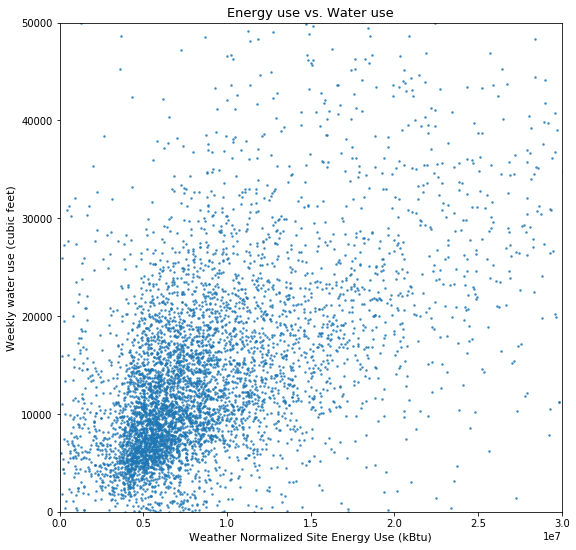

In [60]:
plt.figure(figsize=(9,9))
plt.scatter(data['Weather Normalized Site Energy Use (kBtu)'], data['avgW'], alpha=0.7, s=2.5)
plt.xlim(0,30000000)
plt.ylim(0,50000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)

Text(0,0.5,u'Weekly water use (cubic feet)')

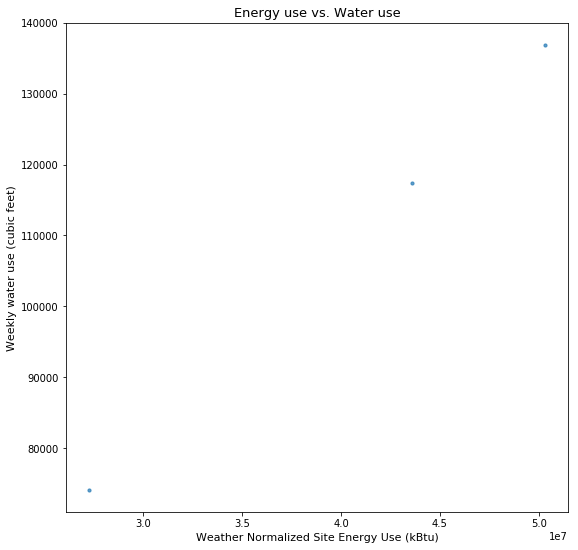

In [61]:
# NYCHA
plt.figure(figsize=(9,9))
plt.scatter(data['Weather Normalized Site Energy Use (kBtu)'][data['BldgType']=='P'], data['avgW'][data['BldgType']=='P'], alpha=0.7, s=10)
#plt.xlim(0,30000000)
#plt.ylim(0,50000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)

Text(0,0.5,u'Weekly water use (cubic feet)')

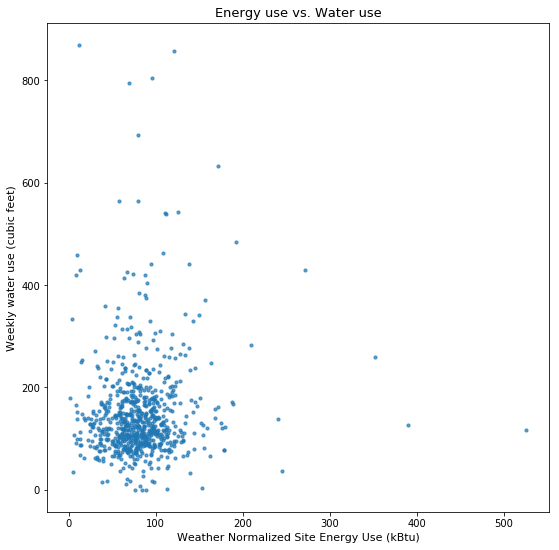

In [62]:
# NYCHA
plt.figure(figsize=(9,9))
plt.scatter(data['Weather Normalized Site EUI (kBtu/ft_2)'][data['BldgType']=='R'], data['avgW_pu'][data['BldgType']=='R'], alpha=0.7, s=10)
#plt.xlim(0,30000000)
#plt.ylim(0,50000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)

### 4) Clustering
* Number of units
* Number of floors
* Built year
* Built floor area ratio
* Number of laundry hookups per unit

In [63]:
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [64]:
data['NumLaundPU'] = (data['NumLaundU'] + data['NumLaundC']) / data['NumResU_cleaned']
data = data[data['BldgType']!='P']
print len(data)

6022


In [65]:
print data.columns.tolist()

['BBL', 'Site EUI (kBtu/ft_2)', 'Weather Normalized Site EUI (kBtu/ft_2)', 'Site Energy Use (kBtu)', 'Weather Normalized Site Energy Use (kBtu)', 'Source EUI (kBtu/ft_2)', 'Weather Normalized Source EUI (kBtu/ft_2)', 'Source Energy Use (kBtu)', 'Weather Normalized Source Energy Use (kBtu)', 'GFA_cleaned', 'NumBedrooms', 'NumLaundU', 'NumLaundC', 'NumResU_cleaned', 'NumResunitsHigh', 'NumResunitsMed', 'Year_cleaned', 'Occ', 'Pcooled', 'Pheated', '15Jan', '15Apr', '15Jul', '15Oct', 'avgW', 'BldgType', 'BldgClass', 'LandUse', 'LotArea', 'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'NumFloors', 'UnitsTotal', 'AssessTot', 'BuiltFAR', 'avgW_pu', 'avgW_sqft', 'percent_res', 'bldgsize', 'bldgage', 'age', 'NumLaundPU']


In [66]:
# Extracting relevant features for clustering
dc = data[['BBL', 'UnitsTotal','NumResU_cleaned','NumFloors', 'Year_cleaned', 'BuiltFAR', 'NumLaundPU']]
dc.head()

,BBL,UnitsTotal,NumResU_cleaned,NumFloors,Year_cleaned,BuiltFAR,NumLaundPU
0,1000087501,98.00,97.00,19.00,1985.00,18.67,0.00
1,1000150022,295.00,293.00,31.00,1931.00,24.93,0.11
2,1000157502,284.00,283.00,45.00,1930.00,12.83,0.06
3,1000160015,209.00,208.00,9.00,1999.00,7.68,0.17
4,1000160020,210.00,209.00,9.00,1998.00,7.77,0.17


In [67]:
n_list = ['UnitsTotal','NumResU_cleaned','NumFloors', 'Year_cleaned', 'BuiltFAR', 'NumLaundPU']
n_list_fake = list(range(len(n_list)))

In [68]:
myarray = dc[['UnitsTotal','NumResU_cleaned','NumFloors', 'Year_cleaned', 'BuiltFAR', 'NumLaundPU']].as_matrix()
print myarray

[[9.80000000e+01 9.70000000e+01 1.90000000e+01 1.98500000e+03
  1.86700000e+01 0.00000000e+00]
 [2.95000000e+02 2.93000000e+02 3.10000000e+01 1.93100000e+03
  2.49300000e+01 1.09215017e-01]
 [2.84000000e+02 2.83000000e+02 4.50000000e+01 1.93000000e+03
  1.28300000e+01 6.36042403e-02]
 ...
 [6.70000000e+01 1.34000000e+02 4.00000000e+00 1.98400000e+03
  7.90000000e-01 0.00000000e+00]
 [1.65000000e+02 1.65000000e+02 2.00000000e+00 1.97400000e+03
  4.50000000e-01 9.69696970e-02]
 [1.08000000e+02 1.08000000e+02 2.00000000e+00 2.01000000e+03
  4.50000000e-01 0.00000000e+00]]


In [69]:
myarray.shape

(6022, 6)

In [70]:
#Z-score normalized 
myarray_norm = np.zeros([6022,6])

for i in range(len(myarray)):
    myarray_norm[i] = stats.zscore(myarray[i])
    
print myarray_norm.shape
print myarray_norm.mean(axis=1)
print myarray_norm.std(axis=1)

(6022, 6)
[-1.85037171e-17  7.40148683e-17  9.25185854e-17 ...  7.40148683e-17
  1.66533454e-16  0.00000000e+00]
[1. 1. 1. ... 1. 1. 1.]


In [71]:
dc.isnull().sum()

BBL                0
UnitsTotal         0
NumResU_cleaned    0
NumFloors          0
Year_cleaned       0
BuiltFAR           0
NumLaundPU         0
dtype: int64

In [72]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [73]:
# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(myarray_norm)
    kmeanModel.fit(myarray_norm)
    distortions.append(sum(np.min(cdist(myarray_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / myarray_norm.shape[0])

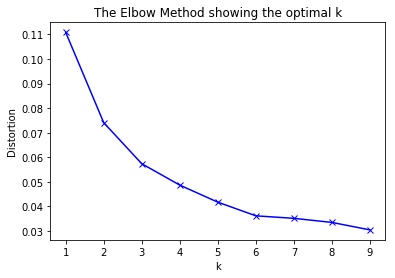

In [74]:
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

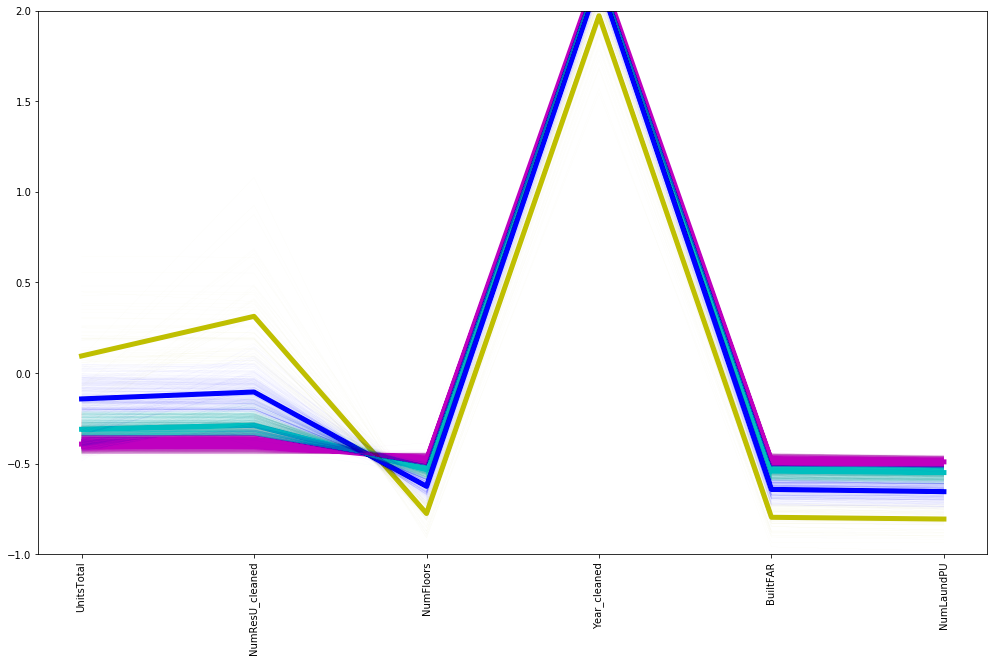

In [75]:
colors=['C', 'M', 'Y', 'Blue']

Kc4 = KMeans(n_clusters=4, n_init=50)
Kc4.fit(myarray_norm)

group_Kc4=Kc4.predict(myarray_norm)

group_Kc4_N = np.zeros([4,6022])
for n in range(4):
    for i in range(len(myarray_norm)):
        if group_Kc4[i]==n:
            group_Kc4_N[n][i]=1
        else:
            group_Kc4_N[n][i]=0

meancenter4 = np.zeros([4,6])

for n in range(len(group_Kc4_N)):
    
    for i in range(len(myarray_norm[0])): #6
    
        A=[]
        for j in range(len(myarray_norm)): #6022
            a=myarray_norm[j][i]*group_Kc4_N[n][j]
            A.append(a)
    
        meancenter4[n][i]=sum(A)/sum(group_Kc4_N[n])

        
        
        
fig = plt.figure(figsize=(17, 10))

#plt.xlim(0,11)
plt.ylim(-1,2)
plt.xticks(n_list_fake[:], n_list[:], rotation='vertical')

for i in range(len(group_Kc4_N)):
    plt.plot(n_list_fake,meancenter4[i], color=colors[i], linewidth=5)

for i in range(len(myarray_norm)):
    for n in range(4):
        if group_Kc4[i]==n:
            plt.plot(n_list_fake,myarray_norm[i], color=colors[n] , alpha=0.1, linewidth=0.1)

In [76]:
# colors=['C', 'M', 'Y', 'Blue']

# Kc3 = KMeans(n_clusters=3, n_init=50)
# Kc3.fit(myarray_norm)

# group_Kc3=Kc3.predict(myarray_norm)

# group_Kc3_N = np.zeros([3,6025])
# for n in range(3):
#     for i in range(len(myarray_norm)):
#         if group_Kc3[i]==n:
#             group_Kc3_N[n][i]=1
#         else:
#             group_Kc3_N[n][i]=0

# meancenter3 = np.zeros([3,6])

# for n in range(len(group_Kc3_N)):
    
#     for i in range(len(myarray_norm[0])): #6
    
#         A=[]
#         for j in range(len(myarray_norm)): #6025
#             a=myarray_norm[j][i]*group_Kc3_N[n][j]
#             A.append(a)
    
#         meancenter3[n][i]=sum(A)/sum(group_Kc3_N[n])

        
        
        
# fig = plt.figure(figsize=(17, 10))

# #plt.xlim(0,11)
# plt.ylim(-1,2)
# plt.xticks(n_list_fake[:], n_list[:], rotation='vertical')

# for i in range(len(group_Kc3_N)):
#     plt.plot(n_list_fake,meancenter3[i], color=colors[i], linewidth=5)

# for i in range(len(myarray_norm)):
#     for n in range(3):
#         if group_Kc3[i]==n:
#             plt.plot(n_list_fake,myarray_norm[i], color=colors[n] , alpha=0.1, linewidth=0.1)

In [104]:
re = pd.DataFrame(myarray_norm)
re.columns = ['Unit', 'Res', 'NumFloors', 'Year', 'FAR', 'Laund']
re['BBL'] = dc['BBL']
re['group_4'] = group_Kc4
#re['group_6'] = group_Kc6

re.head()

,Unit,Res,NumFloors,Year,FAR,Laund,BBL,group_4,group_6
0,-0.38,-0.38,-0.48,2.23,-0.49,-0.51,1000087501,1,3
1,-0.20,-0.20,-0.58,2.20,-0.59,-0.63,1000150022,3,2
2,-0.21,-0.21,-0.56,2.20,-0.60,-0.62,1000157502,3,2
3,-0.27,-0.27,-0.55,2.22,-0.55,-0.56,1000160015,0,4
4,-0.27,-0.27,-0.55,2.22,-0.55,-0.56,1000160020,0,4


Text(0,0.5,u'Standardized Water use per unit')

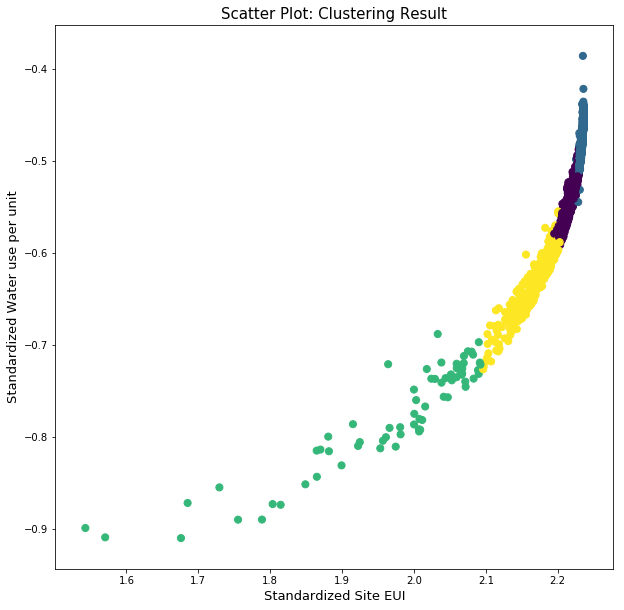

In [94]:
# Plot the result of clustering K=4
plt.figure(figsize=(10,10))
plt.scatter(re['Year'], re['NumFloors'], c=re.group_4, alpha=1, s=50)
plt.title('Scatter Plot: Clustering Result', fontsize=15)
plt.xlabel('Standardized Site EUI', fontsize = 13)
plt.ylabel('Standardized Water use per unit', fontsize = 13)

In [76]:
#re['gruop_3'] = group_Kc3
dc['gruop_4'] = group_Kc4
#re['gruop_6'] = group_Kc6
#re['BBL'] = dc['BBL']
dc.head(2)

,BBL,UnitsTotal,NumResU_cleaned,NumFloors,Year_cleaned,BuiltFAR,NumLaundPU,gruop_4
0,1000087501,98.00,97.00,19.00,1985.00,18.67,0.00,1
1,1000150022,295.00,293.00,31.00,1931.00,24.93,0.11,3


In [79]:
dc = pd.merge(dc[['BBL', 'gruop_4']], data, how='left', on='BBL')
print len(dc)

6022


In [82]:
dc_0 = dc[dc['gruop_4']==0]
dc_1 = dc[dc['gruop_4']==1]
dc_2 = dc[dc['gruop_4']==2]
dc_3 = dc[dc['gruop_4']==3]

In [94]:
# dc_0.to_csv('../data/cluster_0.csv', index=False)
# dc_1.to_csv('../data/cluster_1.csv', index=False)
# dc_2.to_csv('../data/cluster_2.csv', index=False)
# dc_3.to_csv('../data/cluster_3.csv', index=False)

In [95]:
dc_0[['Weather Normalized Site EUI (kBtu/ft_2)', 'Site Energy Use (kBtu)', 
      'avgW', 'avgW_pu', 'GFA_cleaned', 'NumFloors','Year_cleaned', 'BuiltFAR', 'NumLaundPU']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),avgW,avgW_pu,GFA_cleaned,NumFloors,Year_cleaned,BuiltFAR,NumLaundPU
count,1239.00,1239.00,1239.00,1239.00,1239.00,1239.00,1239.00,1239.00,1239.00
mean,101.47,16020372.45,23153.36,139.14,195201.95,12.46,1961.05,6.49,0.16
std,98.13,8157507.56,13713.56,76.57,83148.33,8.98,24.71,5.05,0.35
min,2.80,217207.20,8.50,0.06,53650.00,0.00,1895.00,0.22,0.00
50%,86.30,14529428.20,20050.00,121.75,175436.00,9.00,1961.00,4.40,0.05
max,1852.20,92266520.10,124570.75,808.47,822592.00,58.00,2015.00,32.16,2.67


In [96]:
dc_0['BldgType'].value_counts(normalize=True)

D   0.79
R   0.12
C   0.09
Name: BldgType, dtype: float64

In [97]:
dc_1[['Weather Normalized Site EUI (kBtu/ft_2)', 'Site Energy Use (kBtu)', 
      'avgW', 'avgW_pu', 'GFA_cleaned', 'NumFloors','Year_cleaned', 'BuiltFAR', 'NumLaundPU']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),avgW,avgW_pu,GFA_cleaned,NumFloors,Year_cleaned,BuiltFAR,NumLaundPU
count,4354.00,4354.00,4354.00,4354.00,4354.00,4354.00,4354.00,4354.00,4354.00
mean,92.02,6990522.89,11581.15,172.25,87675.64,8.26,1945.77,5.64,0.23
std,327.86,3620500.58,7217.22,104.35,39302.85,4.67,27.89,3.71,0.48
min,1.30,77077.10,0.50,0.01,4200.00,0.00,1850.00,0.02,0.00
50%,81.10,6326952.15,10050.00,145.90,76300.00,6.00,1937.00,4.47,0.06
max,18899.70,74343865.30,63750.00,1112.12,645530.00,65.00,2019.00,88.55,7.95


In [98]:
dc_1['BldgType'].value_counts(normalize=True)

D   0.80
R   0.12
C   0.08
Name: BldgType, dtype: float64

In [99]:
dc_2[['Weather Normalized Site EUI (kBtu/ft_2)', 'Site Energy Use (kBtu)', 
      'avgW', 'avgW_pu', 'GFA_cleaned', 'NumFloors','Year_cleaned', 'BuiltFAR', 'NumLaundPU']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),avgW,avgW_pu,GFA_cleaned,NumFloors,Year_cleaned,BuiltFAR,NumLaundPU
count,69.00,69.00,69.00,69.00,69.00,69.00,69.00,69.00,69.00
mean,173.65,59165685.23,77684.28,133.05,785119.83,21.94,1967.62,6.96,0.16
std,372.82,22292762.24,26708.40,79.13,240030.27,14.50,21.41,6.92,0.29
min,22.50,9289189.30,28097.00,49.12,277000.00,2.00,1913.00,0.44,0.00
50%,91.40,57738466.50,76262.50,115.43,766080.00,21.00,1964.00,4.25,0.04
max,2846.20,96993611.90,139500.00,656.69,1470000.00,76.00,2013.00,28.43,1.18


In [100]:
dc_2['BldgType'].value_counts(normalize=True)

D   0.74
R   0.17
C   0.09
Name: BldgType, dtype: float64

In [101]:
dc_3[['Weather Normalized Site EUI (kBtu/ft_2)', 'Site Energy Use (kBtu)', 
      'avgW', 'avgW_pu', 'GFA_cleaned', 'NumFloors','Year_cleaned', 'BuiltFAR', 'NumLaundPU']].describe(percentiles=[.5])

,Weather Normalized Site EUI (kBtu/ft_2),Site Energy Use (kBtu),avgW,avgW_pu,GFA_cleaned,NumFloors,Year_cleaned,BuiltFAR,NumLaundPU
count,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00,360.00
mean,127.31,34422040.49,45172.16,127.06,396824.06,20.60,1967.26,8.75,0.17
std,246.79,13535043.66,24675.08,62.65,121884.59,13.32,23.99,7.32,0.35
min,5.10,1121713.60,598.00,1.97,100550.00,2.00,1880.00,0.31,0.00
50%,92.50,33122089.40,40067.50,114.93,378241.50,19.00,1965.00,7.48,0.05
max,3740.10,87276213.20,151900.00,593.69,937758.00,70.00,2011.00,52.69,2.01


In [102]:
dc_3['BldgType'].value_counts(normalize=True)

D   0.76
R   0.18
C   0.06
Name: BldgType, dtype: float64

### 5) Correlation test of each group
* 4 groups
* Pearson correlation test 
* Scatter plot

In [109]:
dc_0[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']].corr()

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),1.00,0.27,-0.00,0.03,0.00,0.00,0.15,0.17,-0.01,-0.05,-0.14
Weather Normalized Site Energy Use (kBtu),0.27,1.00,0.39,0.15,-0.07,0.73,0.46,0.50,0.48,0.17,0.43
avgW,-0.00,0.39,1.00,0.82,0.73,0.34,0.31,0.26,0.40,0.07,0.17
avgW_pu,0.03,0.15,0.82,1.00,0.76,0.12,0.13,0.01,-0.11,-0.07,-0.04
avgW_sqft,0.00,-0.07,0.73,0.76,1.00,-0.28,-0.08,-0.14,0.05,-0.08,-0.15
GFA_cleaned,0.00,0.73,0.34,0.12,-0.28,1.00,0.59,0.59,0.47,0.21,0.48
NumBedrooms,0.15,0.46,0.31,0.13,-0.08,0.59,1.00,0.60,0.37,0.11,0.20
NumResU_cleaned,0.17,0.50,0.26,0.01,-0.14,0.59,0.60,1.00,0.57,0.16,0.27
UnitsTotal,-0.01,0.48,0.40,-0.11,0.05,0.47,0.37,0.57,1.00,0.24,0.41
Year_cleaned,-0.05,0.17,0.07,-0.07,-0.08,0.21,0.11,0.16,0.24,1.00,0.33


In [108]:
calculate_pvalues(dc_0[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),0.00,0.00,0.97,0.33,0.89,0.89,0.00,0.00,0.63,0.06,0.00
Weather Normalized Site Energy Use (kBtu),0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
avgW,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
avgW_pu,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.00,0.02,0.21
avgW_sqft,0.89,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00
GFA_cleaned,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NumBedrooms,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NumResU_cleaned,0.00,0.00,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00
UnitsTotal,0.63,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00
Year_cleaned,0.06,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Text(0,0.5,u'Weekly water use (cubic feet)')

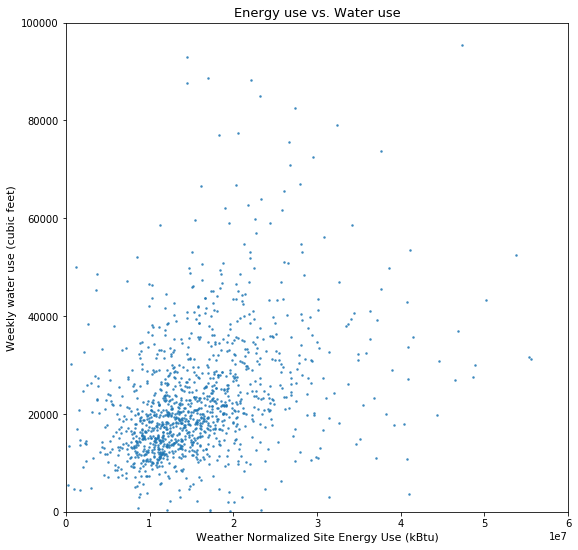

In [112]:
plt.figure(figsize=(9,9))
plt.scatter(dc_0['Weather Normalized Site Energy Use (kBtu)'], dc_0['avgW'], alpha=0.7, s=2.5)
plt.xlim(0,60000000)
plt.ylim(0,100000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)

In [113]:
dc_1[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']].corr()

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),1.00,0.03,-0.00,-0.00,0.01,-0.03,-0.04,0.01,-0.01,0.00,-0.02
Weather Normalized Site Energy Use (kBtu),0.03,1.00,0.31,0.11,-0.03,0.60,0.40,0.38,0.38,0.05,0.31
avgW,-0.00,0.31,1.00,0.75,0.80,0.27,0.28,0.35,0.39,-0.00,-0.05
avgW_pu,-0.00,0.11,0.75,1.00,0.75,0.04,-0.01,-0.15,-0.20,-0.10,-0.02
avgW_sqft,0.01,-0.03,0.80,0.75,1.00,-0.25,-0.03,0.05,0.09,-0.09,-0.28
GFA_cleaned,-0.03,0.60,0.27,0.04,-0.25,1.00,0.53,0.46,0.42,0.11,0.42
NumBedrooms,-0.04,0.40,0.28,-0.01,-0.03,0.53,1.00,0.54,0.50,0.07,0.14
NumResU_cleaned,0.01,0.38,0.35,-0.15,0.05,0.46,0.54,1.00,0.86,0.19,0.01
UnitsTotal,-0.01,0.38,0.39,-0.20,0.09,0.42,0.50,0.86,1.00,0.19,0.04
Year_cleaned,0.00,0.05,-0.00,-0.10,-0.09,0.11,0.07,0.19,0.19,1.00,0.14


In [114]:
calculate_pvalues(dc_1[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),0.00,0.03,0.86,0.93,0.45,0.09,0.02,0.73,0.68,0.88,0.18
Weather Normalized Site Energy Use (kBtu),0.03,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00
avgW,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.76,0.00
avgW_pu,0.93,0.00,0.00,0.00,0.00,0.01,0.40,0.00,0.00,0.00,0.14
avgW_sqft,0.45,0.07,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00
GFA_cleaned,0.09,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NumBedrooms,0.02,0.00,0.00,0.40,0.09,0.00,0.00,0.00,0.00,0.00,0.00
NumResU_cleaned,0.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.48
UnitsTotal,0.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02
Year_cleaned,0.88,0.00,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Text(0,0.5,u'Weekly water use (cubic feet)')

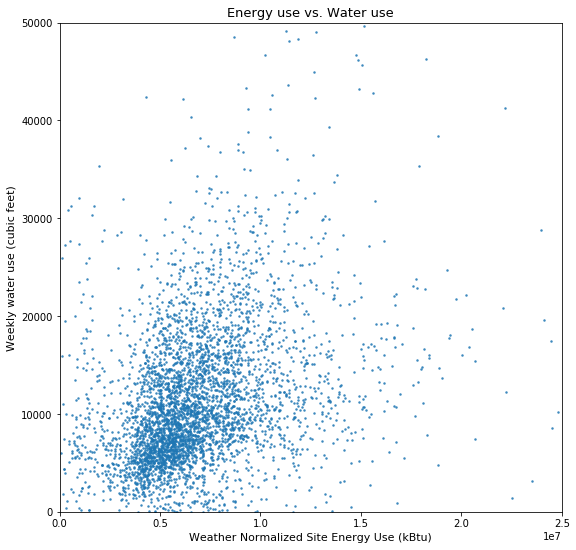

In [116]:
plt.figure(figsize=(9,9))
plt.scatter(dc_1['Weather Normalized Site Energy Use (kBtu)'], dc_1['avgW'], alpha=0.7, s=2.5)
plt.xlim(0,25000000)
plt.ylim(0,50000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)

In [117]:
dc_2[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']].corr()

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),1.00,0.10,-0.08,-0.05,-0.09,0.05,0.19,0.12,-0.07,-0.17,-0.29
Weather Normalized Site Energy Use (kBtu),0.10,1.00,0.25,0.05,-0.27,0.58,0.32,0.35,0.33,0.10,0.15
avgW,-0.08,0.25,1.00,0.57,0.59,0.15,0.18,0.12,0.28,-0.11,-0.01
avgW_pu,-0.05,0.05,0.57,1.00,0.26,0.12,0.09,-0.04,-0.47,-0.14,-0.17
avgW_sqft,-0.09,-0.27,0.59,0.26,1.00,-0.59,-0.29,-0.29,0.15,-0.28,-0.15
GFA_cleaned,0.05,0.58,0.15,0.12,-0.59,1.00,0.69,0.71,0.13,0.15,0.09
NumBedrooms,0.19,0.32,0.18,0.09,-0.29,0.69,1.00,0.76,0.08,-0.02,-0.20
NumResU_cleaned,0.12,0.35,0.12,-0.04,-0.29,0.71,0.76,1.00,0.32,0.02,-0.07
UnitsTotal,-0.07,0.33,0.28,-0.47,0.15,0.13,0.08,0.32,1.00,0.18,0.34
Year_cleaned,-0.17,0.10,-0.11,-0.14,-0.28,0.15,-0.02,0.02,0.18,1.00,0.67


In [118]:
calculate_pvalues(dc_2[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),0.00,0.41,0.49,0.71,0.47,0.68,0.12,0.32,0.55,0.15,0.01
Weather Normalized Site Energy Use (kBtu),0.41,0.00,0.04,0.66,0.02,0.00,0.01,0.00,0.01,0.42,0.21
avgW,0.49,0.04,0.00,0.00,0.00,0.22,0.15,0.31,0.02,0.38,0.94
avgW_pu,0.71,0.66,0.00,0.00,0.03,0.31,0.48,0.74,0.00,0.25,0.15
avgW_sqft,0.47,0.02,0.00,0.03,0.00,0.00,0.02,0.02,0.23,0.02,0.21
GFA_cleaned,0.68,0.00,0.22,0.31,0.00,0.00,0.00,0.00,0.28,0.23,0.47
NumBedrooms,0.12,0.01,0.15,0.48,0.02,0.00,0.00,0.00,0.51,0.89,0.11
NumResU_cleaned,0.32,0.00,0.31,0.74,0.02,0.00,0.00,0.00,0.01,0.89,0.59
UnitsTotal,0.55,0.01,0.02,0.00,0.23,0.28,0.51,0.01,0.00,0.13,0.00
Year_cleaned,0.15,0.42,0.38,0.25,0.02,0.23,0.89,0.89,0.13,0.00,0.00


Text(0,0.5,u'Weekly water use (cubic feet)')

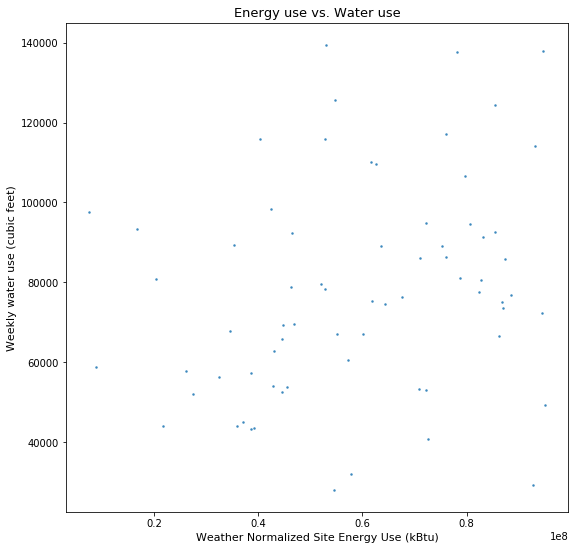

In [120]:
plt.figure(figsize=(9,9))
plt.scatter(dc_2['Weather Normalized Site Energy Use (kBtu)'], dc_2['avgW'], alpha=0.7, s=2.5)
#plt.xlim(0,25000000)
#plt.ylim(0,50000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)

In [121]:
dc_3[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']].corr()

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),1.00,0.15,0.01,0.02,0.01,0.01,0.15,0.15,-0.03,-0.08,-0.18
Weather Normalized Site Energy Use (kBtu),0.15,1.00,0.46,0.28,0.10,0.64,0.35,0.45,0.42,0.20,0.30
avgW,0.01,0.46,1.00,0.86,0.81,0.34,0.34,0.29,0.44,0.07,0.08
avgW_pu,0.02,0.28,0.86,1.00,0.79,0.16,0.22,0.08,-0.01,0.03,-0.06
avgW_sqft,0.01,0.10,0.81,0.79,1.00,-0.20,0.10,0.00,0.19,-0.09,-0.13
GFA_cleaned,0.01,0.64,0.34,0.16,-0.20,1.00,0.38,0.51,0.45,0.18,0.34
NumBedrooms,0.15,0.35,0.34,0.22,0.10,0.38,1.00,0.53,0.31,-0.05,-0.05
NumResU_cleaned,0.15,0.45,0.29,0.08,0.00,0.51,0.53,1.00,0.53,0.05,0.17
UnitsTotal,-0.03,0.42,0.44,-0.01,0.19,0.45,0.31,0.53,1.00,0.12,0.33
Year_cleaned,-0.08,0.20,0.07,0.03,-0.09,0.18,-0.05,0.05,0.12,1.00,0.50


In [122]:
calculate_pvalues(dc_3[['Weather Normalized Site EUI (kBtu/ft_2)', 
      'Weather Normalized Site Energy Use (kBtu)',
     'avgW', 'avgW_pu', 'avgW_sqft', 
     'GFA_cleaned', 'NumBedrooms', 'NumResU_cleaned', 'UnitsTotal', 'Year_cleaned', 'NumFloors']])

,Weather Normalized Site EUI (kBtu/ft_2),Weather Normalized Site Energy Use (kBtu),avgW,avgW_pu,avgW_sqft,GFA_cleaned,NumBedrooms,NumResU_cleaned,UnitsTotal,Year_cleaned,NumFloors
Weather Normalized Site EUI (kBtu/ft_2),0.00,0.01,0.80,0.64,0.84,0.91,0.00,0.00,0.60,0.14,0.00
Weather Normalized Site Energy Use (kBtu),0.01,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00
avgW,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.15
avgW_pu,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.13,0.81,0.61,0.27
avgW_sqft,0.84,0.06,0.00,0.00,0.00,0.00,0.06,0.95,0.00,0.09,0.01
GFA_cleaned,0.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NumBedrooms,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.31,0.35
NumResU_cleaned,0.00,0.00,0.00,0.13,0.95,0.00,0.00,0.00,0.00,0.31,0.00
UnitsTotal,0.60,0.00,0.00,0.81,0.00,0.00,0.00,0.00,0.00,0.02,0.00
Year_cleaned,0.14,0.00,0.19,0.61,0.09,0.00,0.31,0.31,0.02,0.00,0.00


Text(0,0.5,u'Weekly water use (cubic feet)')

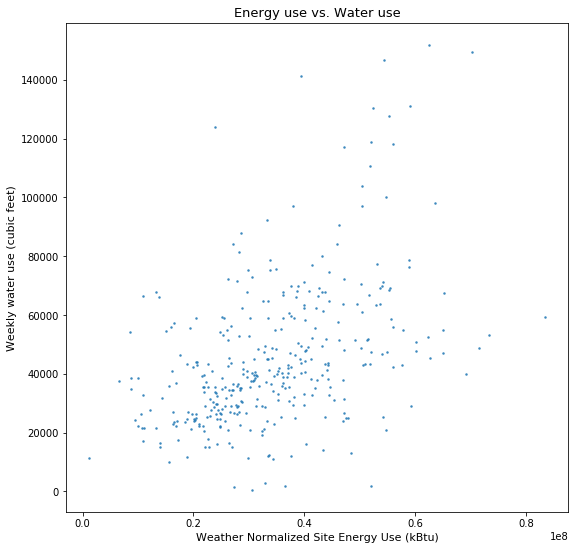

In [123]:
plt.figure(figsize=(9,9))
plt.scatter(dc_3['Weather Normalized Site Energy Use (kBtu)'], dc_3['avgW'], alpha=0.7, s=2.5)
#plt.xlim(0,25000000)
#plt.ylim(0,50000)
plt.title("Energy use vs. Water use", fontsize=13)
plt.xlabel("Weather Normalized Site Energy Use (kBtu)", fontsize=11)
plt.ylabel("Weekly water use (cubic feet)", fontsize=11)